In [23]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import fetch_openml, make_swiss_roll
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

### 3 demensional dataset

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
X[:10]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496],
       [ 1.11816122,  0.32508721,  0.31710572],
       [-1.02258878, -0.64384064, -0.13368695],
       [ 0.67351984, -0.27342519, -0.00787835],
       [ 1.01619558,  0.51546608,  0.46783297],
       [ 0.54957723,  0.67728016,  0.2340159 ]])

### PCA

In [4]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X2D[:10]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049],
       [-1.10436914,  0.20204953],
       [ 1.27265808,  0.46781247],
       [-0.44933007,  0.67736663],
       [-1.09356195, -0.04467792],
       [-0.66177325, -0.28651264]])

Below variance ratio explained how many variance we lost\
First dimension explains 84% of variance\
Second dimension explains 14% of variance\
**So we lost ~1% of variance using PCA to 3 demensional dataset**

In [5]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

How many demensions we would like to reduce?\
*Using MNIST dataset to visualize*

In [7]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(f"X_train shape = {X_train.shape}")
print(f"X_test shape = {X_test.shape}")

X_train shape = (52500, 784)
X_test shape = (17500, 784)


In [10]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"Minimal number of dimensions to keep 95% of variance = {d}")

Minimal number of dimensions to keep 95% of variance = 154


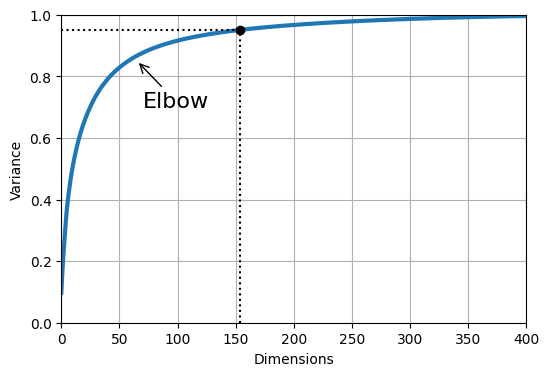

In [12]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### Randomized SVM
It is much faster

In [13]:
pca_rnd = PCA(n_components = 154, svd_solver='randomized')
X_reduced = pca_rnd.fit_transform(X_train)
X_reduced[:10]

array([[-563.82559445,  376.21158528,  547.80926278, ...,   19.38905129,
         -14.8845654 ,   54.51253826],
       [-247.60677316,  594.11581248, -761.17658857, ...,  -71.45002811,
         -35.42725361,   -6.14753115],
       [ -76.10689476, -718.88626737, -621.34715826, ...,  -33.70667711,
          46.79720596,   41.99423193],
       ...,
       [-429.38636261,  711.25073071, -546.40527087, ...,  -15.28839029,
           6.54811678,   -6.89927963],
       [ 150.41912723,  241.31351992, -758.46180526, ...,   62.77701831,
          11.84665153,   -7.8088262 ],
       [   8.89309711,  386.3275416 , -616.01364996, ...,  115.57410984,
          36.67624771,    2.58748549]])

### Incremental PCA 
Worth using for big datasets -> using this we can split dataset to samller groups and pass them to algorithm one by one

In [16]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") 
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
X_reduced[:10]

....................................................................................................

array([[-5.63825831e+02, -3.76211815e+02, -5.47809129e+02, ...,
        -3.46156945e+00,  4.30678698e+01,  5.56272290e+01],
       [-2.47606241e+02, -5.94116271e+02,  7.61177027e+02, ...,
        -7.52110155e+01,  5.34610566e+01, -6.51426217e+00],
       [-7.61072863e+01,  7.18887153e+02,  6.21347670e+02, ...,
        -4.29614186e+01, -2.82591979e+01,  6.51774964e+01],
       ...,
       [-4.29386366e+02, -7.11250622e+02,  5.46405425e+02, ...,
         8.34040306e+00,  1.72142936e+01,  3.01424473e+01],
       [ 1.50418895e+02, -2.41313406e+02,  7.58461959e+02, ...,
         2.75884596e-01,  6.56723075e+00,  1.39839069e+01],
       [ 8.89294708e+00, -3.86326684e+02,  6.16014565e+02, ...,
         6.50384041e+01,  7.40541087e+00,  1.11480699e+00]])

### Kernel PCA
Using to "problematic" data like Swiss Roll data (google it) 

In [18]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [20]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

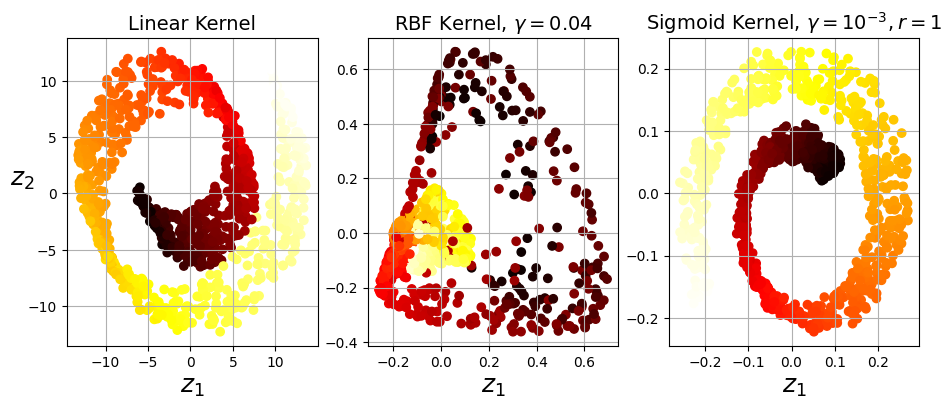

In [22]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear Kernel"), (132, rbf_pca, "RBF Kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid Kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [24]:
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}
